# Encuentra LV+LA, luego se queda con pixeles en todos los datos que tengan interseccion.


--- Finding best ring for: CMRA_HV1.mat ---
Found best ring on slice 120 with score 0.4611

--- Finding best ring for: CMRA_HV2.mat ---
Found best ring on slice 113 with score 0.6612


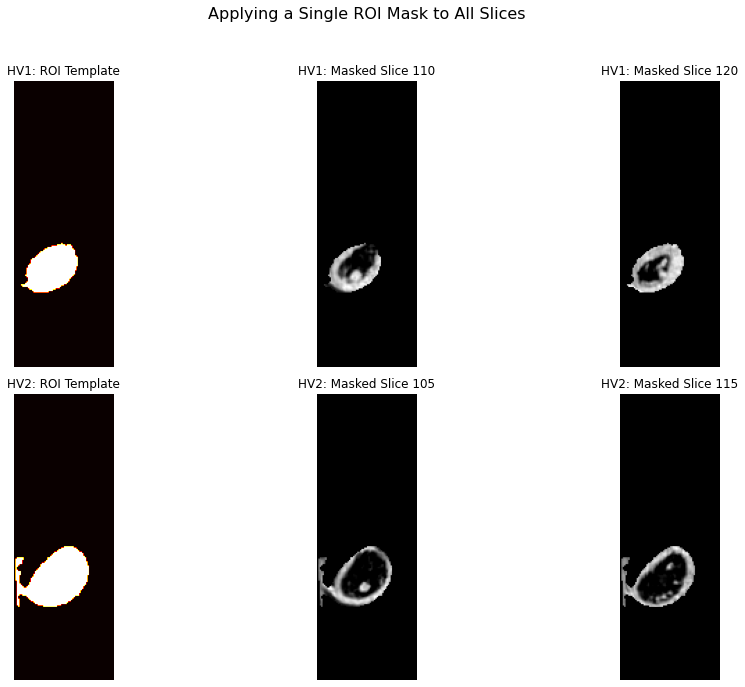

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, binary_opening, binary_erosion, binary_fill_holes
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import os

def find_best_ring_in_slice(image_slice, min_area=100):
    """
    Processes a single 2D image slice to find the most 'ring-like' object.
    (This function is unchanged)
    """
    processed_slice = median_filter(image_slice, size=3)
    if processed_slice.max() == 0: return None, 0.0
    binary_mask = processed_slice > threshold_otsu(processed_slice)
    opened_mask = binary_opening(binary_mask, iterations=1)
    eroded_mask = binary_erosion(opened_mask, iterations=1)
    labeled_blobs, num_labels = label(eroded_mask, return_num=True)
    if num_labels < 1: return None, 0.0
    properties = regionprops(labeled_blobs)
    all_labels = np.array([p.label for p in properties])
    all_areas = np.array([p.area for p in properties])
    all_filled_areas = np.array([p.filled_area for p in properties]) + 1e-6
    large_enough_indices = np.where(all_areas > min_area)[0]
    if len(large_enough_indices) == 0: return None, 0.0
    large_blob_labels = all_labels[large_enough_indices]
    hollowness_ratios = (all_filled_areas[large_enough_indices] - all_areas[large_enough_indices]) / all_filled_areas[large_enough_indices]
    if len(hollowness_ratios) > 0:
        max_hollowness = np.max(hollowness_ratios)
        best_ring_index_in_list = np.argmax(hollowness_ratios)
        the_ring_label = large_blob_labels[best_ring_index_in_list]
        best_ring_mask = np.isin(labeled_blobs, the_ring_label)
        return best_ring_mask, max_hollowness
    else:
        return None, 0.0

def analyze_volunteer_to_find_best_ring(file_path):
    """
    Loads a 3D MRI .mat file and runs the analysis to find the single best ring slice.
    """
    print(f"\n--- Finding best ring for: {os.path.basename(file_path)} ---")
    file_key = 'HV1_black' if 'HV1' in file_path else 'HV2_black'
    with h5py.File(file_path, 'r') as f:
        image_3d = np.transpose(f[file_key][:], (2, 1, 0))
    best_slice_index, max_score, best_mask_found = -1, 0.0, None
    for i in range(image_3d.shape[0]):
        current_mask, current_score = find_best_ring_in_slice(image_3d[i, :, :])
        if current_score > max_score:
            max_score, best_slice_index, best_mask_found = current_score, i, current_mask
    if best_slice_index != -1:
        print(f"Found best ring on slice {best_slice_index} with score {max_score:.4f}")
        return {"image_3d": image_3d, "best_ring_mask": best_mask_found}
    print(f"Could not find a suitable ring in {os.path.basename(file_path)}")
    return None

# --- Main Script ---

folder_path = 'Datos_Proyecto_Final/'
volunteer_files = ["HV1", "HV2"]
all_masked_volumes = {}

for name in volunteer_files:
    file_path = os.path.join(folder_path, f'CMRA_{name}.mat')
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    # --- Step 1: Find the best ring ---
    result = analyze_volunteer_to_find_best_ring(file_path)
    if result is None:
        continue
    
    best_ring_mask = result["best_ring_mask"]
    image_3d = result["image_3d"]
    
    # --- Step 2: Fill it up to create the ROI template ---
    roi_mask = binary_fill_holes(best_ring_mask)
    
    # --- Step 3: Iterate again and apply the ROI to all frames ---
    # Create an empty array to store the result
    masked_volume = np.zeros_like(image_3d)
    
    for i in range(image_3d.shape[0]):
        # The core logic: keep only the pixels within the ROI
        masked_volume[i, :, :] = image_3d[i, :, :] * roi_mask
        
    all_masked_volumes[name] = {"original_3d": image_3d, "masked_3d": masked_volume, "roi": roi_mask}

# --- Step 4: Plot the results for both volunteers ---
if all_masked_volumes:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Applying a Single ROI Mask to All Slices', fontsize=16)

    # Plot for Volunteer 1
    if "HV1" in all_masked_volumes:
        res1 = all_masked_volumes["HV1"]
        # Show the ROI template
        axes[0, 0].imshow(res1["roi"], cmap='hot')
        axes[0, 0].set_title('HV1: ROI Template')
        # Show some example masked slices
        axes[0, 1].imshow(res1["masked_3d"][110, :, :], cmap='gray')
        axes[0, 1].set_title('HV1: Masked Slice 110')
        axes[0, 2].imshow(res1["masked_3d"][120, :, :], cmap='gray')
        axes[0, 2].set_title('HV1: Masked Slice 120')

    # Plot for Volunteer 2
    if "HV2" in all_masked_volumes:
        res2 = all_masked_volumes["HV2"]
        # Show the ROI template
        axes[1, 0].imshow(res2["roi"], cmap='hot')
        axes[1, 0].set_title('HV2: ROI Template')
        # Show some example masked slices
        axes[1, 1].imshow(res2["masked_3d"][105, :, :], cmap='gray')
        axes[1, 1].set_title('HV2: Masked Slice 105')
        axes[1, 2].imshow(res2["masked_3d"][115, :, :], cmap='gray')
        axes[1, 2].set_title('HV2: Masked Slice 115')

    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Calcula volumen con todos los datos que tengan interseccion, luego watershed para dividir LA+LV en LA y en LV.


--- Finding best ring for: CMRA_HV1.mat ---
Found best ring on slice 120

--- Results for HV1 ---
  Total Estimated Volume: 131.29 ml
  LV Proportion from best slice: 37.9%
  FINAL ESTIMATED LV VOLUME: 49.81 ml
  FINAL ESTIMATED LA VOLUME: 81.48 ml


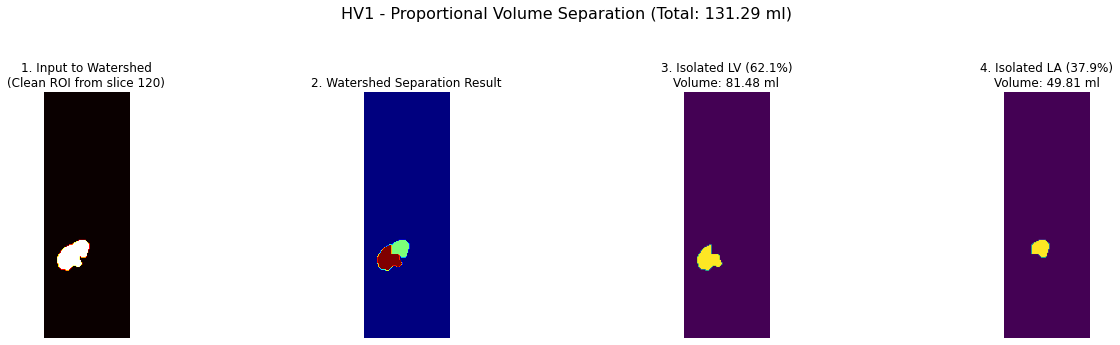


--- Finding best ring for: CMRA_HV2.mat ---
Found best ring on slice 113

--- Results for HV2 ---
  Total Estimated Volume: 257.45 ml
  LV Proportion from best slice: 60.0%
  FINAL ESTIMATED LV VOLUME: 154.52 ml
  FINAL ESTIMATED LA VOLUME: 102.93 ml


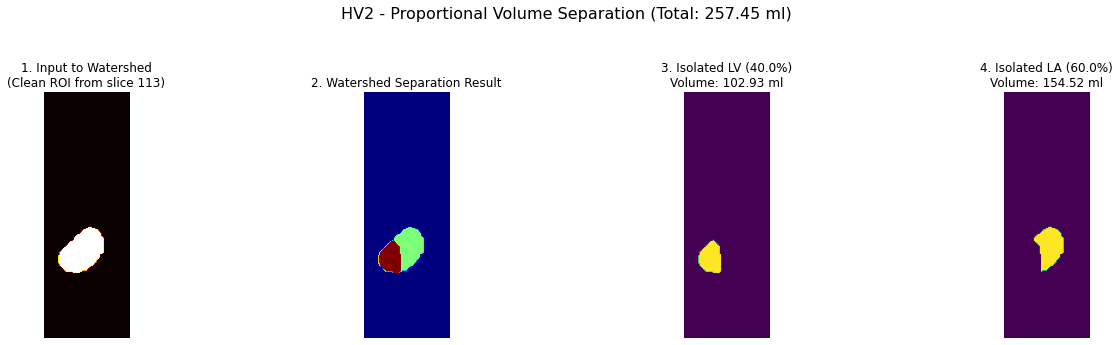

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import median_filter, binary_opening, binary_erosion, binary_fill_holes
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.segmentation import watershed
import os

# --- Using the EXACT "great code" functions you provided ---

def find_best_ring_in_slice(image_slice, min_area=100):
    """Processes a single 2D image slice to find the most 'ring-like' object."""
    processed_slice = median_filter(image_slice, size=3)
    if processed_slice.max() == 0: return None, 0.0
    binary_mask = processed_slice > threshold_otsu(processed_slice)
    opened_mask = binary_opening(binary_mask, iterations=1)
    eroded_mask = binary_erosion(opened_mask, iterations=1)
    labeled_blobs, num_labels = label(eroded_mask, return_num=True)
    if num_labels < 1: return None, 0.0
    properties = regionprops(labeled_blobs)
    all_labels = np.array([p.label for p in properties])
    all_areas = np.array([p.area for p in properties])
    all_filled_areas = np.array([p.filled_area for p in properties]) + 1e-6
    large_enough_indices = np.where(all_areas > min_area)[0]
    if len(large_enough_indices) == 0: return None, 0.0
    large_blob_labels = all_labels[large_enough_indices]
    hollowness_ratios = (all_filled_areas[large_enough_indices] - all_areas[large_enough_indices]) / all_filled_areas[large_enough_indices]
    if len(hollowness_ratios) > 0:
        max_hollowness = np.max(hollowness_ratios)
        best_ring_index_in_list = np.argmax(hollowness_ratios)
        the_ring_label = large_blob_labels[best_ring_index_in_list]
        best_ring_mask = np.isin(labeled_blobs, the_ring_label)
        return best_ring_mask, max_hollowness
    else:
        return None, 0.0

def analyze_volunteer_to_find_best_ring(file_path):
    """Loads a 3D MRI .mat file and runs the analysis to find the single best ring slice."""
    print(f"\n--- Finding best ring for: {os.path.basename(file_path)} ---")
    file_key = 'HV1_black' if 'HV1' in file_path else 'HV2_black'
    with h5py.File(file_path, 'r') as f:
        image_3d = np.transpose(f[file_key][:], (2, 1, 0))
    best_slice_index, max_score, best_mask_found = -1, 0.0, None
    for i in range(image_3d.shape[0]):
        current_mask, current_score = find_best_ring_in_slice(image_3d[i, :, :])
        if current_score > max_score:
            max_score, best_slice_index, best_mask_found = current_score, i, current_mask
    if best_slice_index != -1:
        print(f"Found best ring on slice {best_slice_index}")
        return {"image_3d": image_3d, "best_ring_mask": best_mask_found, "slice_index": best_slice_index}
    return None

def calculate_total_volume_from_roi(image_3d, roi_mask):
    """Applies a 2D ROI to a 3D volume, thresholds, and calculates total volume."""
    masked_volume = image_3d * roi_mask
    final_binary_volume = np.zeros_like(masked_volume, dtype=bool)
    for i in range(masked_volume.shape[0]):
        slice_2d = masked_volume[i, :, :]
        if np.any(slice_2d > 0):
            pixels_in_roi = slice_2d[slice_2d > 0]
            threshold = threshold_otsu(pixels_in_roi)
            final_binary_volume[i, :, :] = slice_2d > threshold
    total_voxel_count = np.sum(final_binary_volume)
    total_volume_ml = (total_voxel_count * 1.5**3) / 1000.0
    return total_volume_ml

# --- Your provided iterative watershed functions ---
def watershed_separation_with_parameter(blob_mask, dist_threshold):
    distance = ndimage.distance_transform_edt(blob_mask)
    max_dist = distance.max()
    if not max_dist > 0: return np.zeros_like(blob_mask), 0, 0
    candidate_markers_mask = (distance > dist_threshold * max_dist)
    candidate_labels, num_candidates = ndimage.label(candidate_markers_mask)
    if num_candidates < 2: return np.zeros_like(blob_mask), 0, 0
    areas = np.bincount(candidate_labels.ravel())[1:]
    sorted_labels_by_area = np.argsort(areas)[::-1] + 1
    marker1 = (candidate_labels == sorted_labels_by_area[0])
    marker2 = (candidate_labels == sorted_labels_by_area[1])
    markers = ndimage.label(marker1 | marker2)[0]
    labels_ws = watershed(-distance, markers, mask=blob_mask)
    area1 = np.sum(labels_ws == 1)
    area2 = np.sum(labels_ws == 2)
    return labels_ws, area1, area2

def find_best_split(blob_mask):
    """Iterative watershed to find the most balanced 50/50 split."""
    threshold_candidates = np.arange(0.05, 1.0, 0.025)
    stored_results, stored_scores = [], []
    for threshold in threshold_candidates:
        labels, area1, area2 = watershed_separation_with_parameter(blob_mask, threshold)
        balance_score = min(area1, area2) / (max(area1, area2) + 1e-6) if (area1 > 0 and area2 > 0) else 0
        stored_scores.append(balance_score)
        stored_results.append(labels)
    if not stored_scores or max(stored_scores) == 0: return np.zeros_like(blob_mask)
    best_index = np.argmax(stored_scores)
    return stored_results[best_index]

# --- Main Script ---
folder_path = 'Datos_Proyecto_Final/'
volunteer_files = ["HV1", "HV2"]

for name in volunteer_files:
    file_path = os.path.join(folder_path, f'CMRA_{name}.mat')
    if not os.path.exists(file_path): continue
    
    # 1. Find the best myocardial ring using the trusted function
    result = analyze_volunteer_to_find_best_ring(file_path)
    if result is None: continue
    
    image_3d = result["image_3d"]
    best_idx = result["slice_index"]
    myocardium_ring_mask = result["best_ring_mask"]
    
    # 2. Create the clean, 2D "hollow part" ROI
    lv_la_pool_roi = binary_fill_holes(myocardium_ring_mask) & ~myocardium_ring_mask
    
    # 3. Calculate the TOTAL volume using the approved method
    total_volume_ml = calculate_total_volume_from_roi(image_3d, lv_la_pool_roi)
    
    # 4. Apply watershed to the CLEAN 2D ROI to find the proportion
    segmented_2d_mask = find_best_split(lv_la_pool_roi)
    if np.sum(segmented_2d_mask) == 0:
        print(f"Watershed separation failed for {name}.")
        continue
        
    # 5. Calculate proportion and final volumes
    area_lv = np.sum(segmented_2d_mask == 1)
    area_la = np.sum(segmented_2d_mask == 2)
    total_area = area_lv + area_la
    if total_area == 0: continue
    proportion_lv = area_lv / total_area
    proportion_la = area_la / total_area
    final_lv_volume = total_volume_ml * proportion_lv
    final_la_volume = total_volume_ml * proportion_la
    
    print(f"\n--- Results for {name} ---")
    print(f"  Total Estimated Volume: {total_volume_ml:.2f} ml")
    print(f"  LV Proportion from best slice: {proportion_lv:.1%}")
    print(f"  FINAL ESTIMATED LV VOLUME: {final_lv_volume:.2f} ml")
    print(f"  FINAL ESTIMATED LA VOLUME: {final_la_volume:.2f} ml")
    
    # 6. Visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'{name} - Proportional Volume Separation (Total: {total_volume_ml:.2f} ml)', fontsize=16)
    
    axes[0].imshow(lv_la_pool_roi, cmap='hot')
    axes[0].set_title(f'1. Input to Watershed\n(Clean ROI from slice {best_idx})')
    
    axes[1].imshow(segmented_2d_mask, cmap='jet')
    axes[1].set_title('2. Watershed Separation Result')
    
    # --- SWAPPED PLOTTING LOGIC AS REQUESTED ---
    # Plot LA in the 3rd position
    axes[2].imshow(segmented_2d_mask == 2, cmap='viridis')
    axes[2].set_title(f'3. Isolated LV ({proportion_la:.1%})\nVolume: {final_la_volume:.2f} ml')
    
    # Plot LV in the 4th position
    axes[3].imshow(segmented_2d_mask == 1, cmap='viridis')
    axes[3].set_title(f'4. Isolated LA ({proportion_lv:.1%})\nVolume: {final_lv_volume:.2f} ml')
    
    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()